In [67]:
!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.16.0 requires torch==2.1.0, but you have torch 2.8.0 which is incompatible.


In [68]:
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

## Text Processing

In [69]:
single_document = "./documents/HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf"

In [70]:
# Open the pdf document
with pdfplumber.open(single_document) as pdf:
    # Extract text from each page
    document_text = ""
    page3 = pdf.pages[2]
    document_text += page3.extract_text()
    tables = page3.extract_tables()
print(document_text[:500])  # Print the first 500 characters of the document
print('----------')
print(tables)  # Print the extracted tables

POLICY SCHEDULE
1. Master Policy Number:<< system/operations generated>>
2. Date of Proposal:<<<< system/operations generated>>
3. Date of Inception: <<Date of Inception>>
4. Effective Date:<< system/operations service generated>>
5. Master Policyholder:<<Name of Company/Group>>
6. Name of the Scheme:<<NAME of Scheme>>
7. Scheme Type:<<Compulsory/Voluntary>>
8. Plan option:<<Name of Plan option>>
9. Eligibility to join the Scheme for the Scheme Member:
Eligibility Age (Last Birthday) (in years)

----------
[[['Eligibility', 'Age (Last Birthday) (in years)', None, None], ['Minimum Age at Entry', '< 18 >', None, None], ['Maximum Age at Entry', 'Single Premium Payment', 'Life Option', '<79 >'], [None, None, 'Extra Life Option &\nAccelerated Critical Illness\nOption', '<74>'], ['', 'Limited Premium\nPayment', 'Life Option', '<74 >'], [None, None, 'Extra Life Option & Accelerated\nCritical Illness Option', '<69>'], ['', 'Regular Premium\nPayment', 'Life Option', '<78 >'], [None, None, 'Extr

In [71]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [72]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

In [73]:
# Define the directory containing the PDF files
pdf_directory = Path("./documents/")

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing HDFC-Life-Group-Term-Life-Policy.pdf
Finished processing HDFC-Life-Group-Term-Life-Policy.pdf
...Processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
Finished processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
...Processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
Finished processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
...Processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
Finished processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
...Processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
Finished processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
...Processing HDFC-Surgicare-Plan-101N043V01.pdf
Finished processing HDFC-Surgicare-Plan-101N043V01.pdf
...Processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
Finished processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Poli

In [74]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)


In [75]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,HDFC Life Group Term Life OF «OWNERNAME» Based...,HDFC-Life-Group-Term-Life-Policy.pdf
1,Page 2,PART A: Covering Letter with Policy Schedule <...,HDFC-Life-Group-Term-Life-Policy.pdf
2,Page 3,Address : Mobile/Landline Number : A1 Free Loo...,HDFC-Life-Group-Term-Life-Policy.pdf
3,Page 4,"[[""Name of Policy"", ""HDFC Life Group Term Life...",HDFC-Life-Group-Term-Life-Policy.pdf
4,Page 5,"[[""Policy No."", """"], [""Name & Address of Polic...",HDFC-Life-Group-Term-Life-Policy.pdf
...,...,...,...
212,Page 40,,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...
213,Page 41,,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...
214,Page 42,,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...
215,Page 43,,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...


In [76]:
insurance_pdfs_data.Page_Text[4]


'[["Policy No.", ""], ["Name & Address of Policyholder:", "Policy Commencement date: <<dd/mm/yyyy>>"], [null, "Risk Commencement Date/ Date at inception: <<dd/mm/yyyy>>"], [null, "Risk Commencement date for new members:\\n<<first Day of the calendar Month>>\\n<<Date of Joining the Group>>\\n<<Date of intimation>>"], [null, "Frequency of Premium Payment:\\n<<Monthly>> <<Quarterly>> Half-Yearly>> <<Yearly>>"], [null, "Premium Due Date:\\n<<Monthly: ..st Day of every month till xx month of 20\\u2026 >>\\n<<Quarterly: ..st Day of xx,yy,zz months of 20\\u2026 >>\\n<<Half-Yearly: ..st Day of xx Month of 20\\u2026 >>\\n<<Yearly: ..st Day of xx Month of 20\\u2026 >>"], [null, "Cover Cessation Date: <<dd/mm/yyyy>>"], [null, "Policy Renewal Date: <<dd/mm/yyyy>>"], [null, "Grace Period Expiry Date: <<dd/mm/yyyy>>"], ["Nature of Business", ""], ["Benefit Expiry Age", "<< >> Years last birthday"], ["Insured Members: As per the Coverage Schedule", null], ["Sum Assured:\\nAs mentioned in the policy d

## Chunking & Embeddings


In [77]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [78]:
insurance_pdfs_data['Text_Length']


0       57
1      400
2      618
3       67
4      174
      ... 
212      1
213      1
214      1
215      1
216      1
Name: Text_Length, Length: 217, dtype: int64

In [79]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,HDFC Life Group Term Life OF «OWNERNAME» Based...,HDFC-Life-Group-Term-Life-Policy.pdf,57
1,Page 2,PART A: Covering Letter with Policy Schedule <...,HDFC-Life-Group-Term-Life-Policy.pdf,400
2,Page 3,Address : Mobile/Landline Number : A1 Free Loo...,HDFC-Life-Group-Term-Life-Policy.pdf,618
3,Page 4,"[[""Name of Policy"", ""HDFC Life Group Term Life...",HDFC-Life-Group-Term-Life-Policy.pdf,67
4,Page 5,"[[""Policy No."", """"], [""Name & Address of Polic...",HDFC-Life-Group-Term-Life-Policy.pdf,174
...,...,...,...,...
206,Page 34,Paid-up Addition Factor per Re. 1 Cash Bonus u...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,18
207,Page 35,ANNEXURE – V Cash Value Factor per Re.1 vested...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,20
208,Page 36,Cash Value Factor per Re.1 vested Paid-up Addi...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,17
209,Page 37,Cash Value Factor per Re.1 vested Paid-up Addi...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,17


In [80]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

/var/folders/7d/_tknpwq147sc6bnrbrx98d6c0000gn/T/ipykernel_2048/1081778557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [81]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,HDFC Life Group Term Life OF «OWNERNAME» Based...,HDFC-Life-Group-Term-Life-Policy.pdf,57,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
1,Page 2,PART A: Covering Letter with Policy Schedule <...,HDFC-Life-Group-Term-Life-Policy.pdf,400,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
2,Page 3,Address : Mobile/Landline Number : A1 Free Loo...,HDFC-Life-Group-Term-Life-Policy.pdf,618,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
3,Page 4,"[[""Name of Policy"", ""HDFC Life Group Term Life...",HDFC-Life-Group-Term-Life-Policy.pdf,67,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
4,Page 5,"[[""Policy No."", """"], [""Name & Address of Polic...",HDFC-Life-Group-Term-Life-Policy.pdf,174,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
...,...,...,...,...,...
206,Page 34,Paid-up Addition Factor per Re. 1 Cash Bonus u...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,18,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...
207,Page 35,ANNEXURE – V Cash Value Factor per Re.1 vested...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,20,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...
208,Page 36,Cash Value Factor per Re.1 vested Paid-up Addi...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,17,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...
209,Page 37,Cash Value Factor per Re.1 vested Paid-up Addi...,HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-D...,17,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:

The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
openai.api_key = "sk-**"
chroma_client = chromadb.Client()

In [83]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [84]:
chroma_data_path = './chroma_data'

In [85]:
import chromadb

In [86]:
# Call PersistentClient()

client = chromadb.PersistentClient(chroma_data_path)


In [87]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [88]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [89]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [90]:
# Add the documents and metadata to the collection along with generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [91]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.00748029, -0.01845138, -0.01820878, ..., -0.0199744 ,
          0.0074466 , -0.00896287],
        [-0.01358616,  0.00592487,  0.00712883, ..., -0.01545146,
         -0.01004548, -0.02394366],
        [-0.00602088, -0.00110196,  0.00557263, ...,  0.00400034,
          0.00536888, -0.02711265]]),
 'documents': ['HDFC Life Group Term Life OF «OWNERNAME» Based on the Proposal and the declarations and any statement made or referred to therein, We will pay the Benefits mentioned in this Policy subject to the terms and conditions contained herein << Designation of the Authorised Signatory >> F&U dated 15th October 2022 UIN-101N169V02 P a ge | 0',
  'PART A: Covering Letter with Policy Schedule <dd-mm-yyyy> __________________ __________________ __________________ __________________ __________________ Your HDFC Life <Policy Name> with Policy No. <Policy no.> Dear Mr./Ms.___________________________, We thank you for choosing HDFC Life Insurance 

In [92]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache2', embedding_function=embedding_function)

In [93]:
cache_collection.peek()

{'ids': ['what are accidental death benefits received in a life insurance'],
 'embeddings': array([[-0.01048317,  0.00629838,  0.00252183, ..., -0.02351113,
         -0.02028772, -0.01594742]]),
 'documents': ['what are accidental death benefits received in a life insurance'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'ids6': '37',
   'documents9': 'HDFC Life Smart Pension Plan 101L164V02 – Terms and Conditions (Direct & Online Sales) (A Unit Linked Non-Participating Individual Pension Plan) F.12 Suicide Exclusion: In case of death due to suicide within 12 months from the Date of Commencement of the Policy or from the date of Revival of the Policy, as applicable, the Eligible Person shall be entitled to the Fund Value, as available on the date of intimation of death. Further any charges other than Fund Management charges (FMC) recovered subsequent to the date of death shall be added back to the Fund Value as available on the da

## Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [94]:
# Read the user query

# Run for these 2 sentences one after the other
# 1. what are accidental death benefits received in a life insurance
# 2. What are the benefits on accidental death in life insurance

# query = input()
query = "what are accidental death benefits received in a life insurance"


In [95]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [96]:
cache_results

{'ids': [['what are accidental death benefits received in a life insurance']],
 'embeddings': None,
 'documents': [['what are accidental death benefits received in a life insurance']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'distances4': '0.3610442876815796',
    'ids2': '10',
    'documents3': 'HDFC Life Sanchay Plus (UIN – 101N134V19) – Appendix 9 (c) – Policy Bond A non-participating, non-linked savings insurance plan Part F (General Terms & Conditions) 1. Suicide Exclusions In case of death due to suicide within 12 months from the date of commencement of risk under the policy or from the date of revival of the policy, as applicable, the nominee or beneficiary of the policyholder shall be entitled to at least 80% of the total premiums paid till the date of death or the surrender value available as on the date of death whichever is higher, provided the policy is in force. 2. Age Admitted The Company has calculated the Prem

In [97]:
results = insurance_collection.query(
    query_texts=query,
    n_results=10
)
# results.items()

# show results in dataframe

df = pd.DataFrame(results.items())
df.head()


,0,1
0,ids,"[[140, 177, 10, 79, 132, 190, 37, 133, 129, 52]]"
1,embeddings,None
2,documents,"[[Note: For the purpose of waiting period, Dat..."
3,uris,None
4,included,"[metadatas, documents, distances]"


In [98]:
results_specific = insurance_collection.get(ids=['74'])
results_specific

{'ids': ['74'],
 'embeddings': None,
 'documents': ['HDFC Life Sanchay Plus (UIN – 101N134V19) – Appendix 9 (c) – Policy Bond A non-participating, non-linked savings insurance plan Part C Benefits 1. Benefits: (1) Maturity Benefit – On survival of the Life Assured till the Maturity Date and provided all Premiums which have fallen due have been paid, the Maturity Benefit payable shall be Guaranteed Income on Maturity payable at the end of each Income Payout Frequency as provided under the Policy Schedule, during the Payout Period as mentioned below. Maturity Benefit will be paid as Guaranteed Income starting from (Policy Term + 1)th year till the individual attains age 99 years, in arrears on payment of all due premiums. Please refer to the Guaranteed Income on Maturity value as mentioned in your Policy Schedule. At the end of the Payout Period, the Policy terminates by returning the Total Premiums paid. On the Maturity Date, you shall have an option to receive the Guaranteed Sum Assure

In [99]:
cache_results['distances'][0]


[0.0]

In [100]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

results_count = 10

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If no results found in cache or the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
        query_texts=query,
        n_results=results_count
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []


      for key, val in results.items():
        if val is None:
          continue
        if key == 'included':
          # ignore the included key
          continue
        for i in range(results_count):
          # print(str(key)+str(i), str(val[0][i]))
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      print(query)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Found in cache!


In [101]:
results_df

,IDs,Documents,Distances,Metadatas
0,10,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.3610442876815796,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
1,37,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.30291128158569336,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L..."
2,140,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.3428812026977539,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
3,129,Part B Definitions The following capitalized t...,0.3764689564704895,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
4,133,Part C 1. Benefits: (1) Benefits on Death or d...,0.3642871081829071,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
5,177,PART C Product Core Benefits BENEFITS PAYABLE ...,0.35181933641433716,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...
6,190,"Note: For the purpose of waiting period, Date ...",0.364168643951416,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...
7,132,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.3457036018371582,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L..."
8,79,"(i) Death Certificate, in original, issued by ...",0.3654041290283203,"{'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L..."
9,52,"[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.3717351257801056,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...


## Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

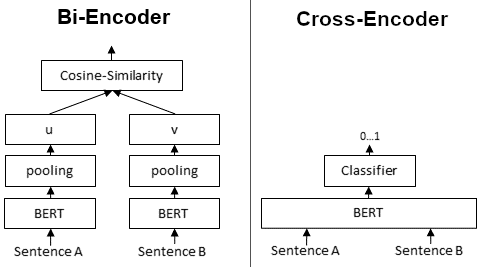

<br>

Here are some of the benefits of using re-ranking in generative search:

- **Improved accuracy and relevance** of the generated results
- **Reduced amount of irrelevant or inaccurate information** presented to the user
- **More personalised and informative search results**
- **Ability to tailor the search results** to specific tasks or domains



Traditionally, many methods of re-ranking have been used in search such as Reciprocal Rank Fusion (RRF), hybrid search methods and cross-encoder models. For this project, we will focus on the popular method of using cross-encoders for our re-ranking task. The image above illustrates the re-ranking component once the search results have been collected by the semantic search layer.

In [102]:
%pip show transformers sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: transformers
Version: 4.56.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /opt/anaconda3/lib/python3.11/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: sentence-transformers
---
Name: sentence-transformers
Version: 5.1.0
Summary: Embeddings, Retrieval, and Reranking
Home-page: 
Author: 
Author-email: Nils Reimers <info@nils-reimers.de>, Tom Aarsen <tom.aarsen@huggingface.co>
License: Apache 2.0
Location: /opt/anaconda3/lib/python3.11/site-packages
Requires: huggingface-hub, Pillow, scikit-learn, scipy, torch, tqdm, transformers, typing_extensions
Required-by: 
Note: you may need to

In [103]:
# !pip uninstall -y transformers sentence-transformers torch huggingface_hub
# !pip install torch==2.1.0 transformers==4.36.0 huggingface_hub==0.19.4
# !pip install sentence-transformers==2.2.2

In [104]:
from sentence_transformers.cross_encoder import CrossEncoder

model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L6-v2")
scores = model.predict([["My first", "sentence pair"], ["Second text", "pair"]])

In [105]:
# Test the cross encoder model

scores = model.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [106]:
scores

array([  3.8467624, -11.25288  ], dtype=float32)

In [107]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = model.predict(cross_inputs)

In [108]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [109]:
results_df


,IDs,Documents,Distances,Metadatas,Reranked_scores
0,10,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.3610442876815796,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,-0.967635
1,37,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.30291128158569336,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...",-0.671022
2,140,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.3428812026977539,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,0.778045
3,129,Part B Definitions The following capitalized t...,0.3764689564704895,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,2.352342
4,133,Part C 1. Benefits: (1) Benefits on Death or d...,0.3642871081829071,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,2.929415
5,177,PART C Product Core Benefits BENEFITS PAYABLE ...,0.35181933641433716,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...,-1.506037
6,190,"Note: For the purpose of waiting period, Date ...",0.364168643951416,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...,5.234123
7,132,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.3457036018371582,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...",-2.416149
8,79,"(i) Death Certificate, in original, issued by ...",0.3654041290283203,"{'Page_No.': 'Page 11', 'Policy_Name': 'HDFC-L...",-1.012303
9,52,"[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.3717351257801056,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...,-2.678208


In [110]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
1,37,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.30291128158569336,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...",-0.671022
2,140,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.3428812026977539,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,0.778045
7,132,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.3457036018371582,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...",-2.416149


In [111]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
6,190,"Note: For the purpose of waiting period, Date ...",0.364168643951416,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...,5.234123
4,133,Part C 1. Benefits: (1) Benefits on Death or d...,0.3642871081829071,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,2.929415
3,129,Part B Definitions The following capitalized t...,0.3764689564704895,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,2.352342


In [112]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
6,"Note: For the purpose of waiting period, Date ...",{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...
4,Part C 1. Benefits: (1) Benefits on Death or d...,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
3,Part B Definitions The following capitalized t...,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [ ]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [114]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [115]:
# Print the response
print("Query:", query)
print("\nTop 3 RAG Results:\n", top_3_RAG)
print("\nResponse:")
print("\n".join(response))

Query: what are accidental death benefits received in a life insurance

Top 3 RAG Results:
                                            Documents  \
6  Note: For the purpose of waiting period, Date ...   
4  Part C 1. Benefits: (1) Benefits on Death or d...   
3  Part B Definitions The following capitalized t...   

                                           Metadatas  
6  {'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...  
4  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  
3  {'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...  

Response:
Accidental death benefits in a life insurance policy typically refer to an additional payout made by the insurance company if the insured person dies due to an accident. This benefit is separate from the regular death benefits provided under the policy.

While the search results do not explicitly mention accidental death benefits, it is important to review the 'Part C: Benefits' section of the insurance document for detailed information related to 